# **STAT 306 Group Project: Predicting Sleep Efficiency**

>##### By: Pahul Brar, Diana Liang, Peng Xie, Jonathan Tuazon

## 1. Introduction

#### Research Question:

Which set of factors plays a significant role in accurately predicting sleep efficiency, and will a linear or quadratic model be the most suitable?

#### Brief Description of the Variables in the Dataset

The dataset used in this project is sourced from [Kaggle](https://www.kaggle.com/datasets/equilibriumm/sleep-efficiency). The following include all the variables measured in the dataset:
- Age (years) 
    - Age of the individual
- Gender (0=Female; 1=Male)
    - Categorical: Subject is male or female
- Bedtime (timestamp: YYYY-MM-DD HH:MM: SS) 
    - Time subject goes to bed
- Wakeup time (timestamp: YYYY-MM-DD HH:MM: SS)
    - Time subject wakes up
- Sleep duration (hours)
    - The total amount of time spent sleeping
- Sleep efficiency
    - proportion of time in bed spent asleep
- REM sleep percentage (%)
    - percentage of sleep duration spent in REM sleep
- Deep sleep percentage (%)
    - percentage of sleep duration spent in Deep sleep
- Light sleep percentage (%)
    - percentage of sleep duration spent in Light sleep
- Awakenings
    - number of times the subject woke up during the night
- Caffeine Consumption (mg)
    - Amount of caffeine consumed in the 24 hours prior to bedtime
- Alcohol Consumption (oz)
    - Amount of alcohol consumed in the 24 hours prior to bedtime
- Smoker (0=Nonsmoker; 1=Smoker)
    - Categorical: subject smokes or does not smoke
- Exercise frequency
    - number of times the subject exercises each week

## 2. Analysis

#### Loading Packages and Cleaning the Dataset

To begin our analysis, we'll read the dataset into a dataframe and omit any entries with missing data.

In [42]:
library(tidyverse)
library(leaps)
library(lubridate)
library(cowplot)
library(ggcorrplot)
library(car)
library(ggplot2)

In [43]:
data <- read.csv("data/Sleep_Efficiency.csv") |>
    relocate(Sleep.efficiency) |>
    na.omit(data) |>
    #select(-c(ID))
    select(-c(Bedtime,Wakeup.time,ID))

data$Smoking.status <- ifelse(data$Smoking.status=="Yes",1,0) |>
    as.factor()
data$Gender <- ifelse(data$Gender=="Male",1,0) |>
    as.factor()
df <- read.csv("data/Sleep_Efficiency.csv") |>
    relocate(Sleep.efficiency) |>
    na.omit(data) |>
    select(Sleep.efficiency,Bedtime,Wakeup.time)

#data$Bedtime <- hour(data$Bedtime)*3600 + minute(data$Bedtime)*60 + second(data$Bedtime)
#data$Wakeup.time <- hour(data$Wakeup.time)*3600 + minute(data$Wakeup.time)*60 + second(data$Wakeup.time)
head(data)

n <- nrow(data)
dim(data)

,Sleep.efficiency,Age,Gender,Sleep.duration,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Smoking.status,Exercise.frequency
,<dbl>,<int>,<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,0.88,65,0,6,18,70,12,0,0,0,1,3
2,0.66,69,1,7,19,28,53,3,0,3,1,3
3,0.89,40,0,8,20,70,10,1,0,0,0,3
4,0.51,40,0,6,23,25,52,3,50,5,1,1
5,0.76,57,1,8,27,55,18,3,0,3,0,3
7,0.54,27,0,6,28,25,47,2,50,0,1,1


[1] 388  12

After preprocessing and cleaning, there are 14 variables and 388 entries in the dataset. 

#### Summary of Statistics

In [44]:
summary(data)

 Sleep.efficiency      Age        Gender  Sleep.duration   REM.sleep.percentage
 Min.   :0.5000   Min.   : 9.00   0:194   Min.   : 5.000   Min.   :15.00       
 1st Qu.:0.7000   1st Qu.:29.00   1:194   1st Qu.: 7.000   1st Qu.:20.00       
 Median :0.8200   Median :41.00           Median : 7.500   Median :22.00       
 Mean   :0.7893   Mean   :40.83           Mean   : 7.451   Mean   :22.68       
 3rd Qu.:0.9000   3rd Qu.:52.00           3rd Qu.: 8.000   3rd Qu.:25.00       
 Max.   :0.9900   Max.   :69.00           Max.   :10.000   Max.   :30.00       
 Deep.sleep.percentage Light.sleep.percentage   Awakenings   
 Min.   :18.00         Min.   : 7.0           Min.   :0.000  
 1st Qu.:51.00         1st Qu.:15.0           1st Qu.:1.000  
 Median :58.00         Median :18.0           Median :1.000  
 Mean   :52.82         Mean   :24.5           Mean   :1.619  
 3rd Qu.:63.00         3rd Qu.:24.0           3rd Qu.:3.000  
 Max.   :75.00         Max.   :63.0           Max.   :4.000  
 Caffe

#### Correlation Matrix

Next, we'll compute and visualize a correlation matrix to better understand the relationships between the variables.

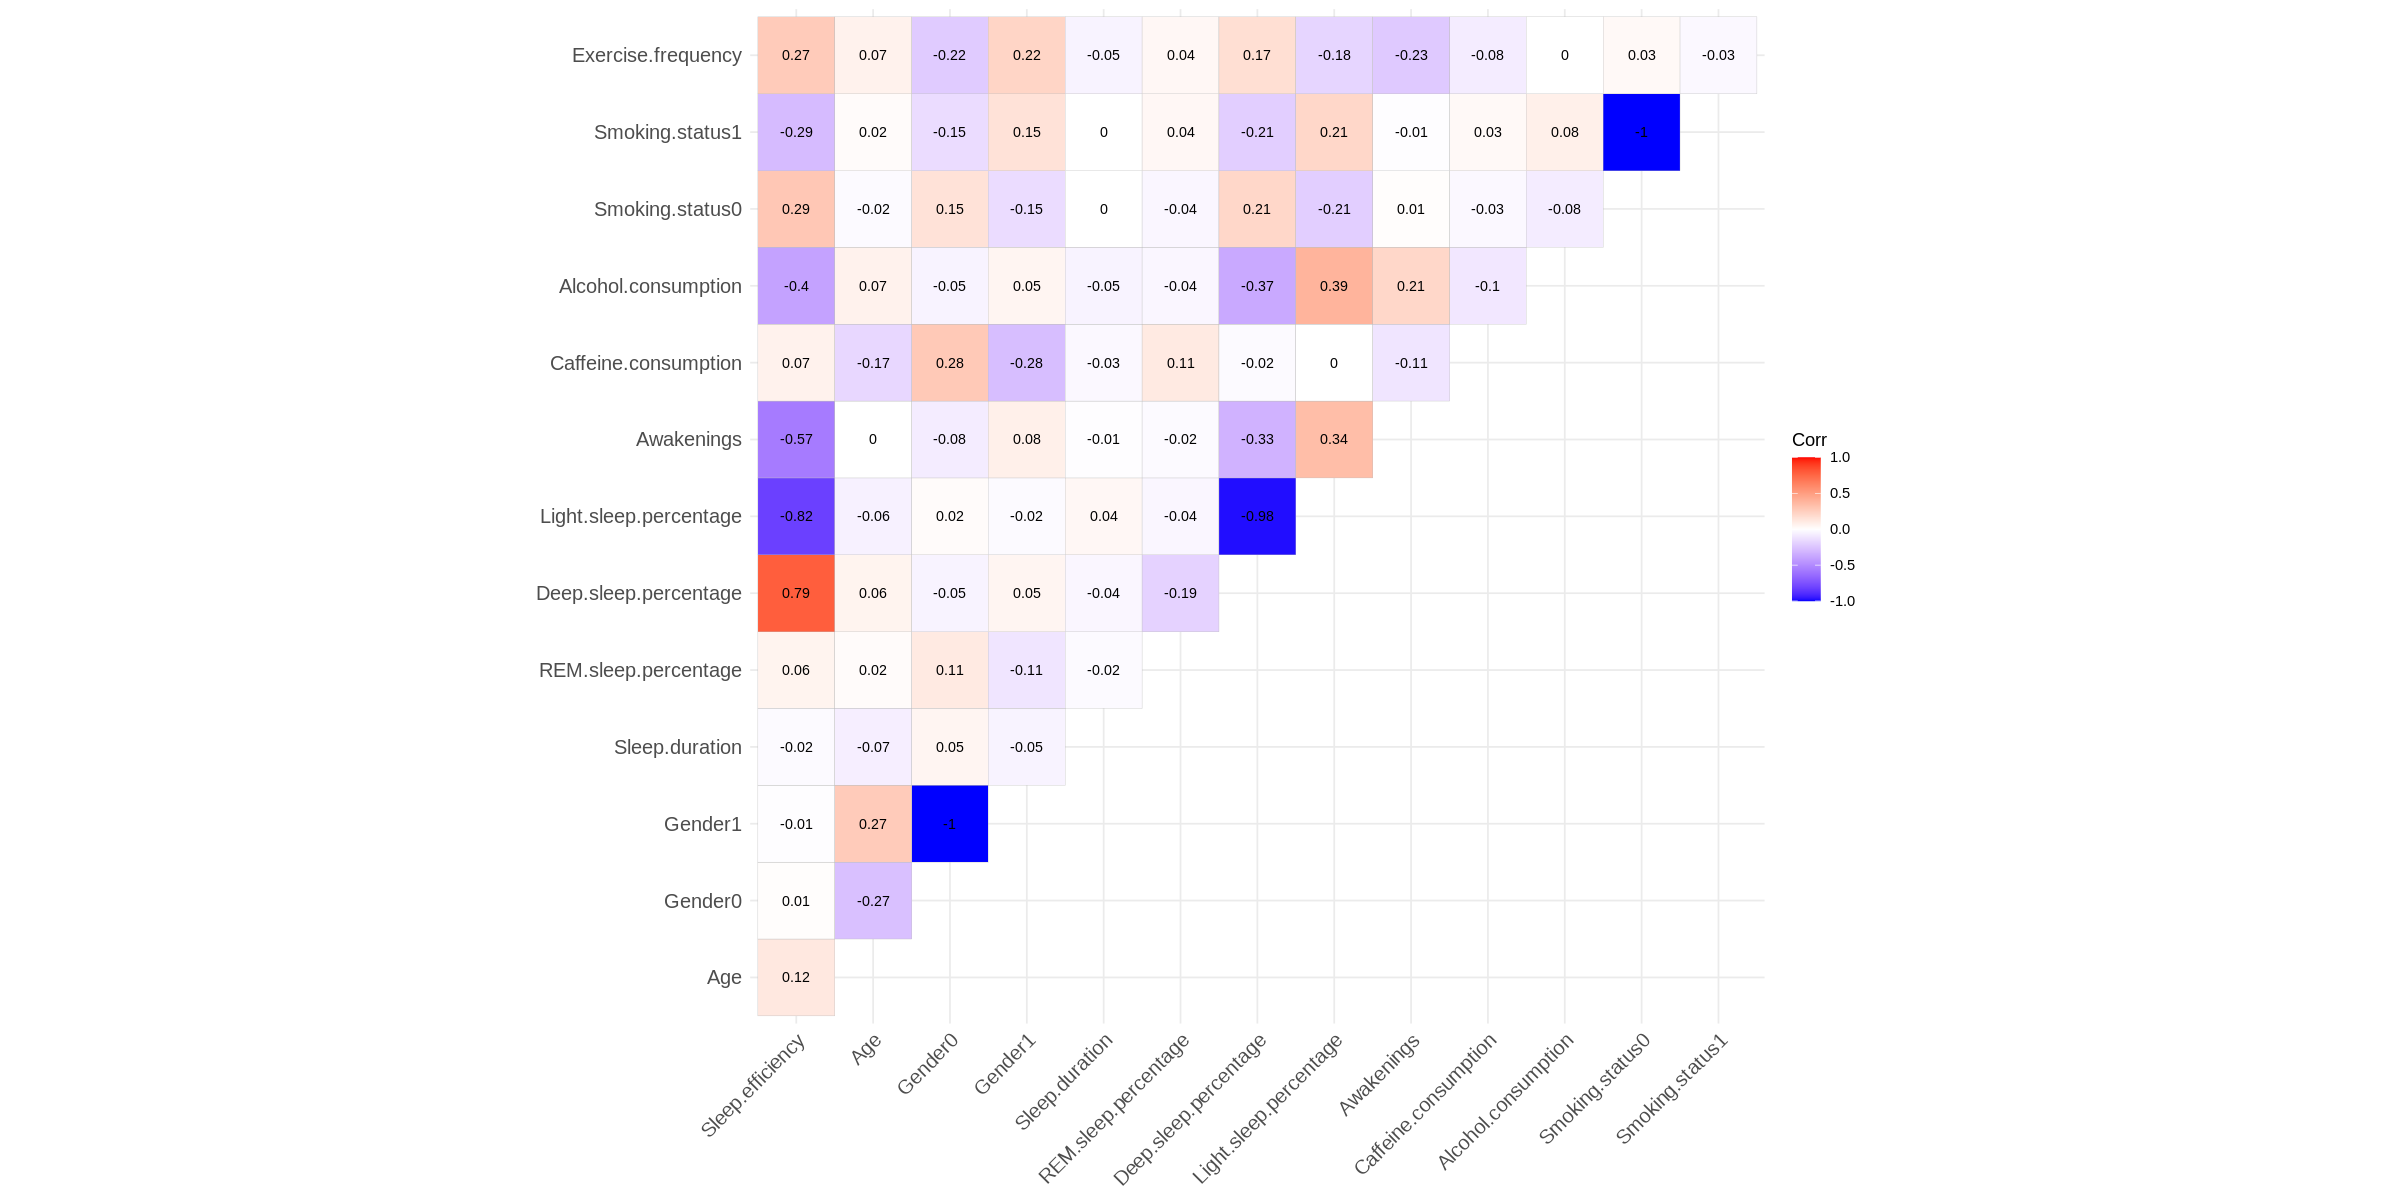

In [45]:
#one-hot encode all non-numeric variables to show correlation matrix
options(repr.plot.width=20,repr.plot.height=10)
model.matrix(~0+., data=data, contrasts.arg = list(Smoking.status = contrasts(data$Smoking.status, contrasts = FALSE))) |> 
  cor(use="pairwise.complete.obs") |> 
  ggcorrplot(show.diag=FALSE, type="upper", lab=TRUE, lab_size=3)

#### Distribution of the Response Variable (Sleep.efficiency)

In [46]:
#create groups based on categorical variables for visualization
plot_age <-ggplot(data, aes(Age, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Age") + ylab("Sleep Efficiency") + xlab("Age (years)")
plot_dur <-ggplot(data, aes(Sleep.duration, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Sleep Duration") + ylab("Sleep Efficiency") + xlab("Sleep duration (hours)")
# plot_bed <-ggplot(data, aes(Bedtime, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
#     scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
#     ggtitle("Sleep Efficiency and Bedtime") + ylab("Sleep Efficiency") + xlab("Bedtime (HH:MM:SS to seconds)")
# plot_wake <-ggplot(data, aes(Wakeup.time, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
#     scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
#     ggtitle("Sleep Efficiency and Wakeup Time") + ylab("Sleep Efficiency") + xlab("Wakeup Time (HH:MM:SS to seconds)")
plot_rem <-ggplot(data, aes(REM.sleep.percentage, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and REM Sleep") + ylab("Sleep Efficiency") + xlab("REM sleep percentage (%)")
plot_deep <-ggplot(data, aes(Deep.sleep.percentage, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Deep Sleep") + ylab("Sleep Efficiency") + xlab("Deep sleep percentage (%)")
plot_light <-ggplot(data, aes(Light.sleep.percentage, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Light Sleep") + ylab("Sleep Efficiency") + xlab("Light sleep percentage (%)")
plot_awake <-ggplot(data, aes(Awakenings, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Awakenings") + ylab("Sleep Efficiency") + xlab("# of times the subject woke up during the night")
plot_caf <-ggplot(data, aes(Caffeine.consumption, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Caffeine Consumption") + ylab("Sleep Efficiency") + xlab("Caffeine Consumption (mg)")
plot_alc <-ggplot(data, aes(Alcohol.consumption, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Alcohol Consumption") + ylab("Sleep Efficiency") + xlab("Alcohol Consumption (oz)")
plot_exer <-ggplot(data, aes(Exercise.frequency, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Exercise Frequency") + ylab("Sleep Efficiency") + xlab("# of times the subject exercises each week")

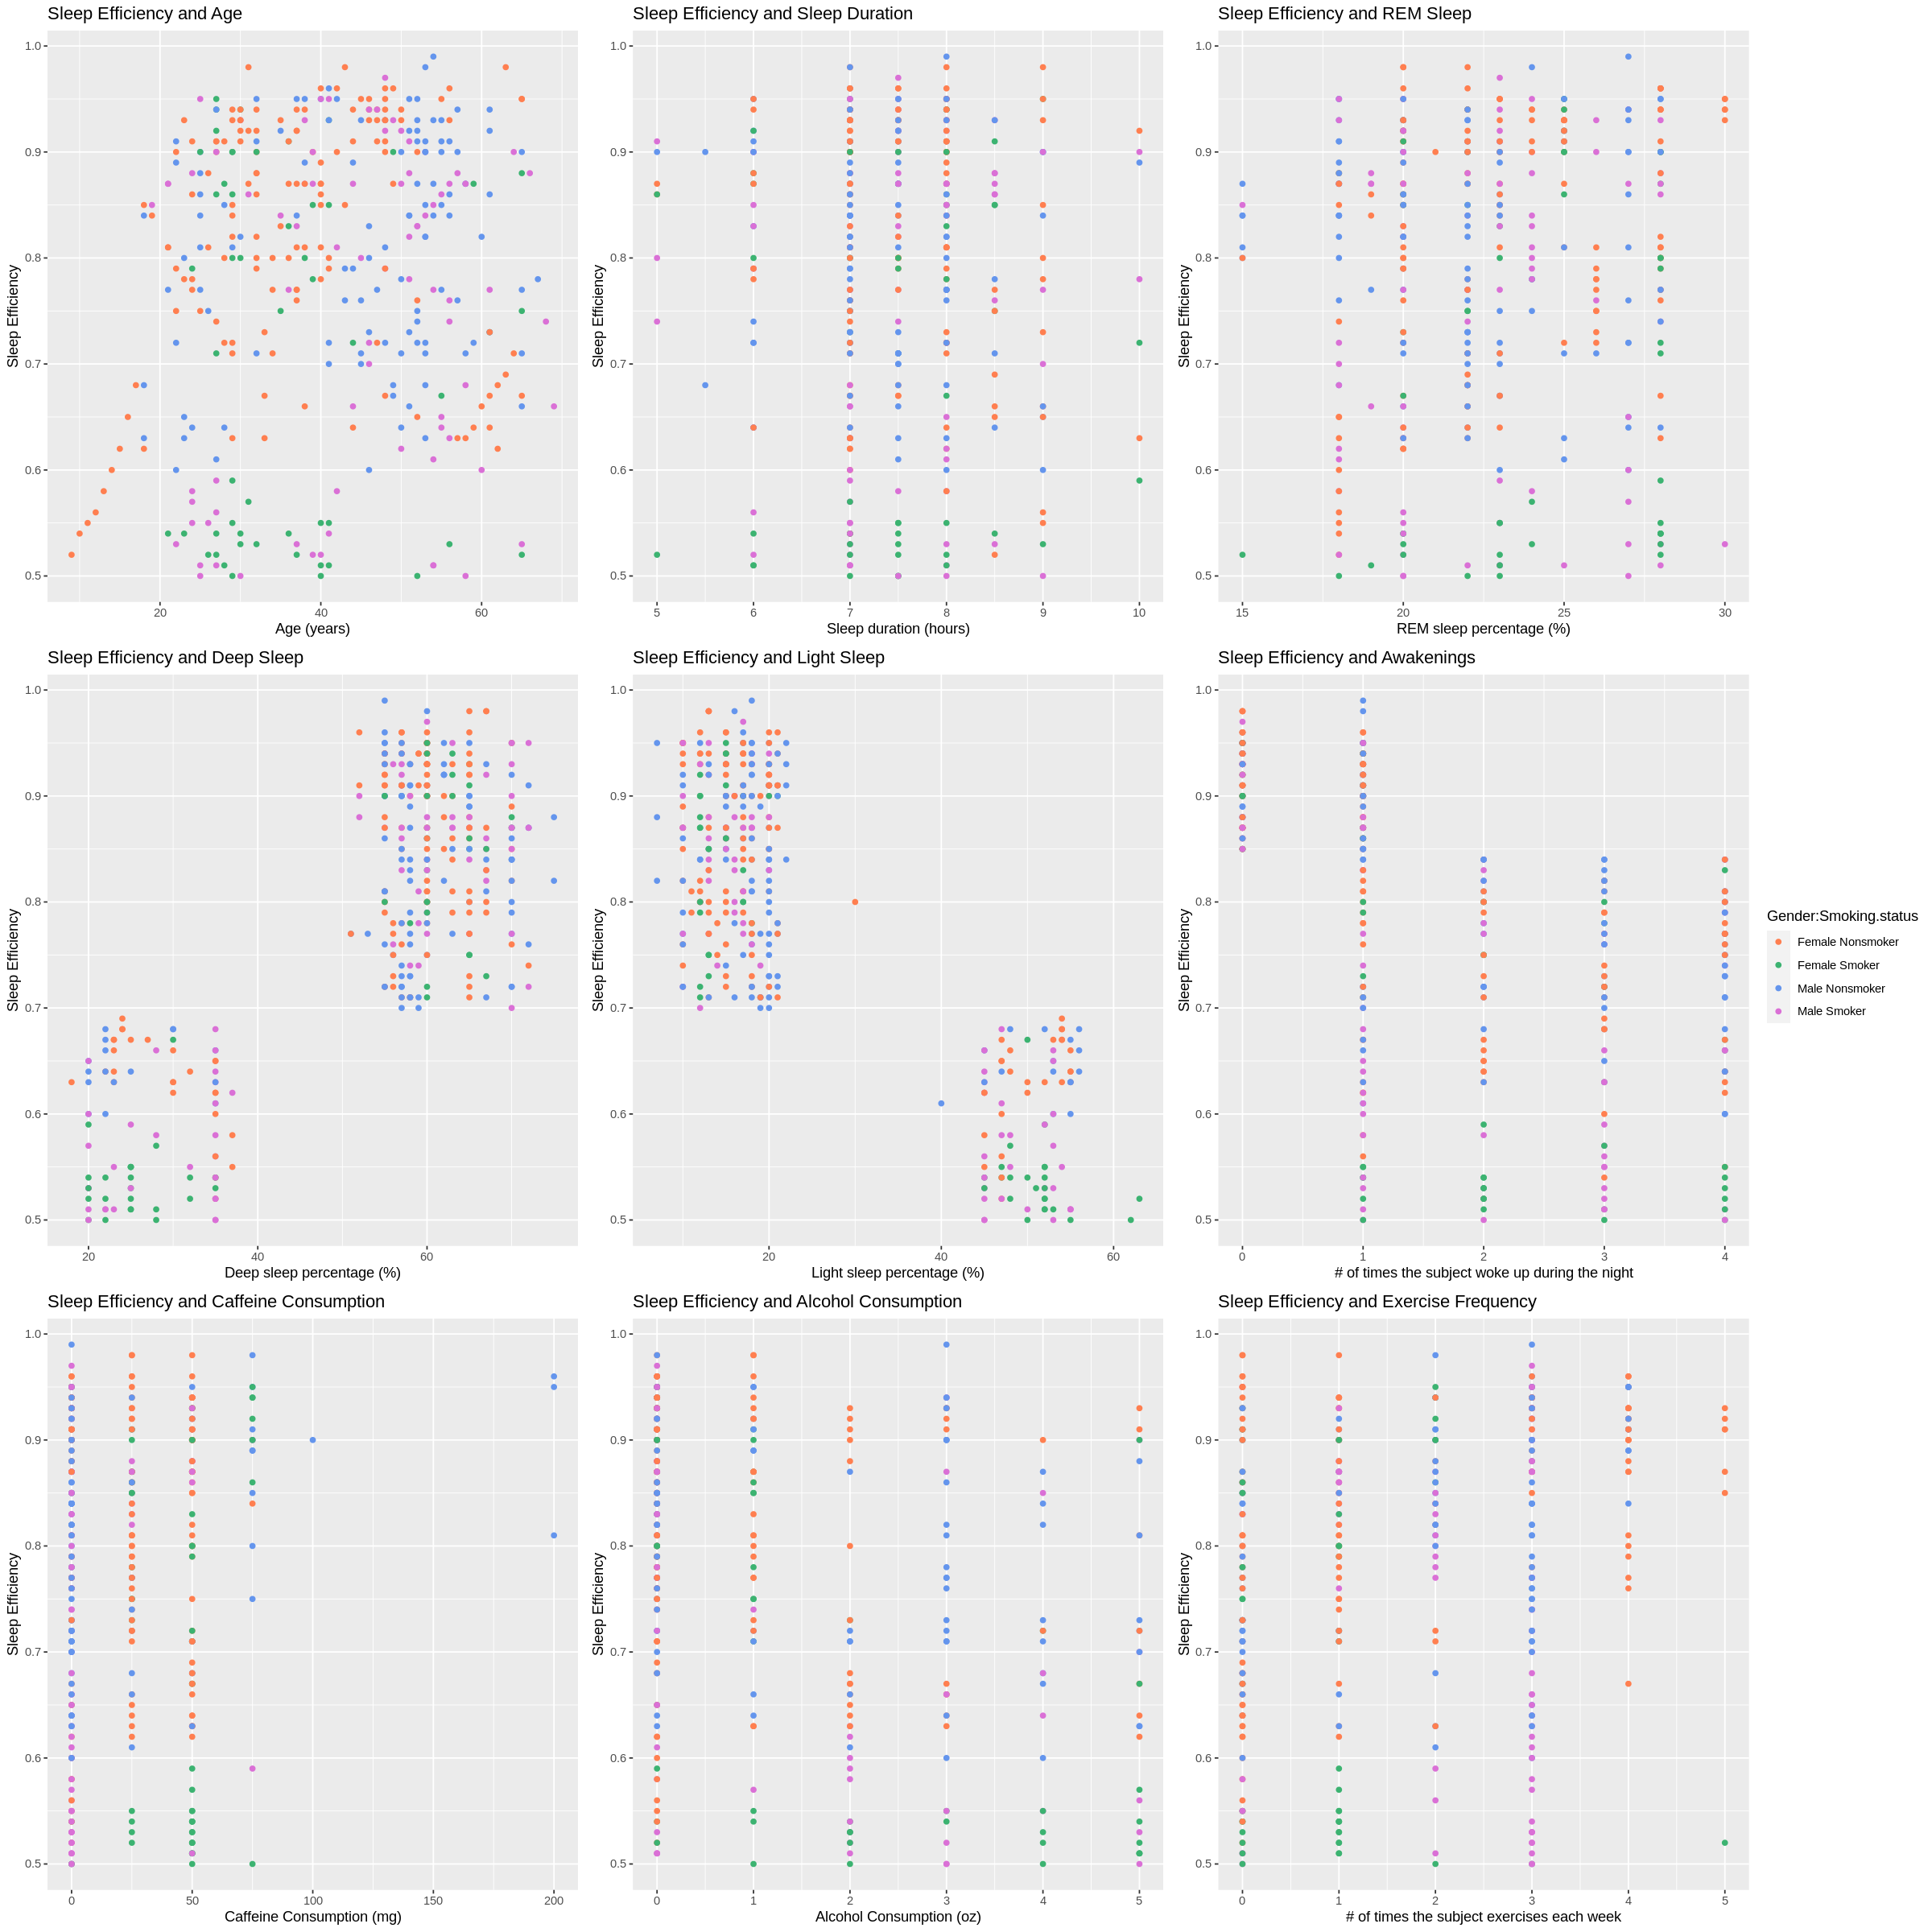

In [47]:
#plot all scatterplots
options(repr.plot.width=20,repr.plot.height=20)
legend<-get_legend(plot_age)

plot_grid(plot_grid(   
plot_grid(
    plot_age + theme(legend.position = 'none'), 
    plot_dur + theme(legend.position = 'none'),
    plot_rem + theme(legend.position = 'none'), 
    ncol=3
),
plot_grid(
    plot_deep + theme(legend.position = 'none'), 
    plot_light + theme(legend.position = 'none'),
    plot_awake + theme(legend.position = 'none'), 
    ncol=3
),

plot_grid(
    plot_caf + theme(legend.position = 'none'), 
    plot_alc + theme(legend.position = 'none'), 
    plot_exer + theme(legend.position = 'none'), 
    ncol=3
),

ncol=1),

plot_grid(legend), rel_widths = c(1, 0.1))


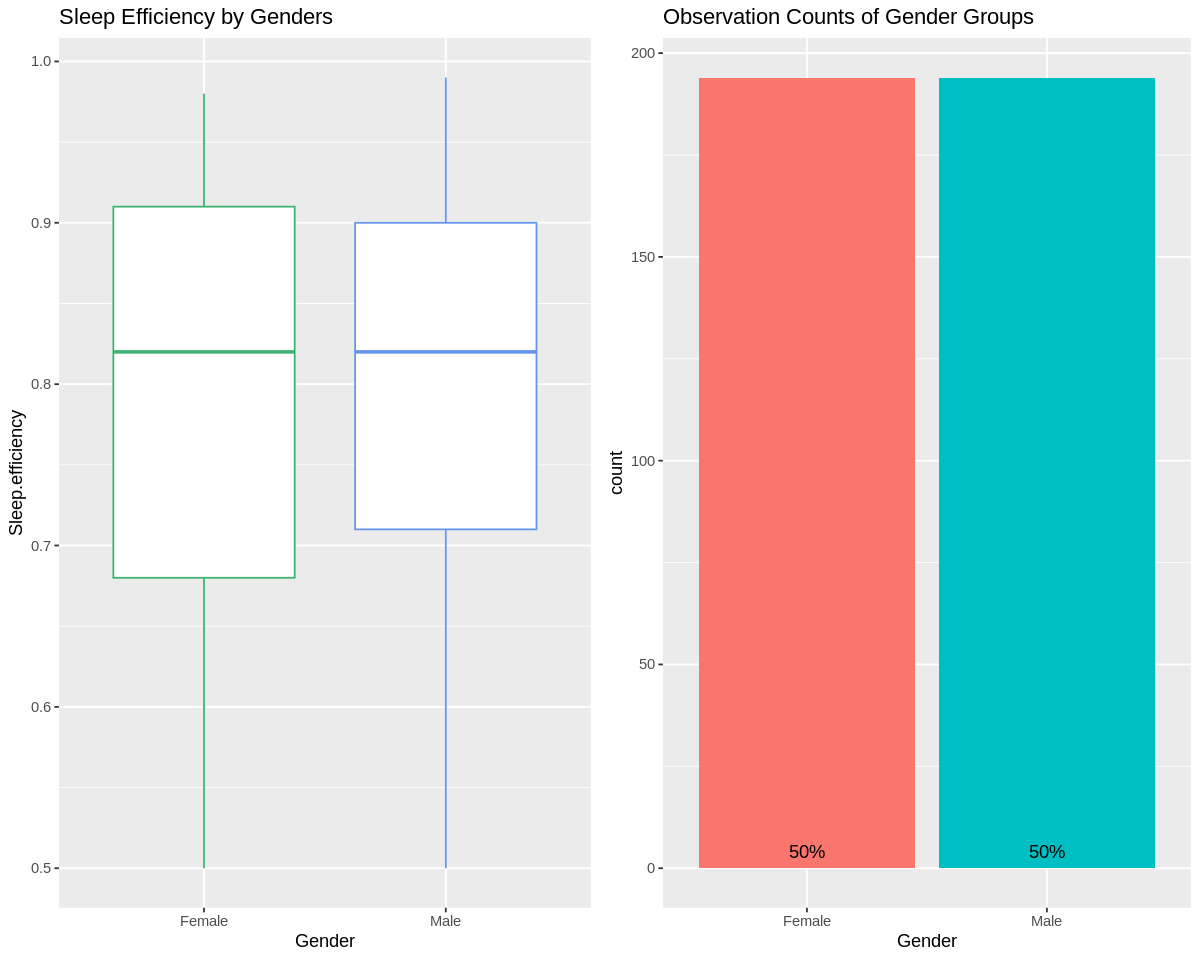

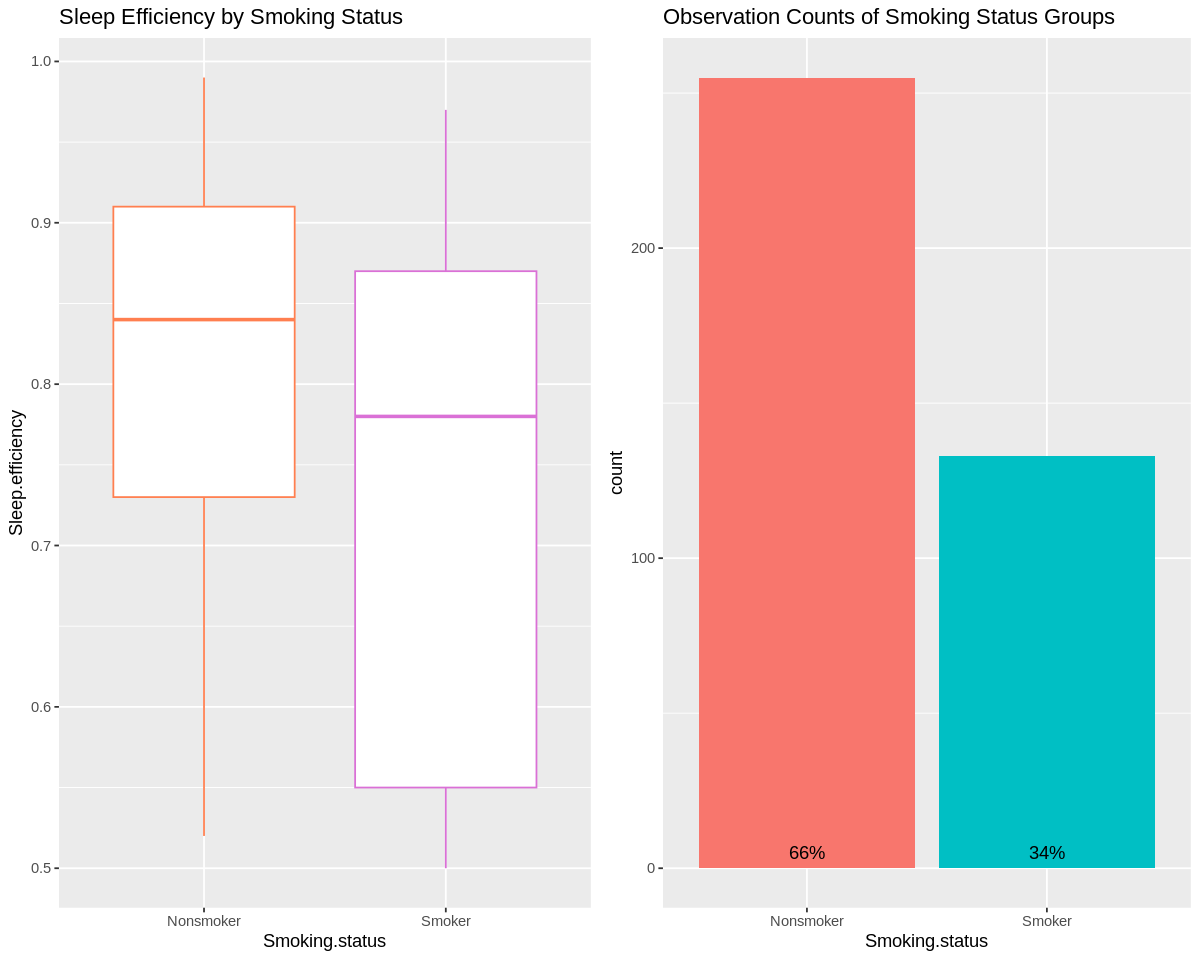

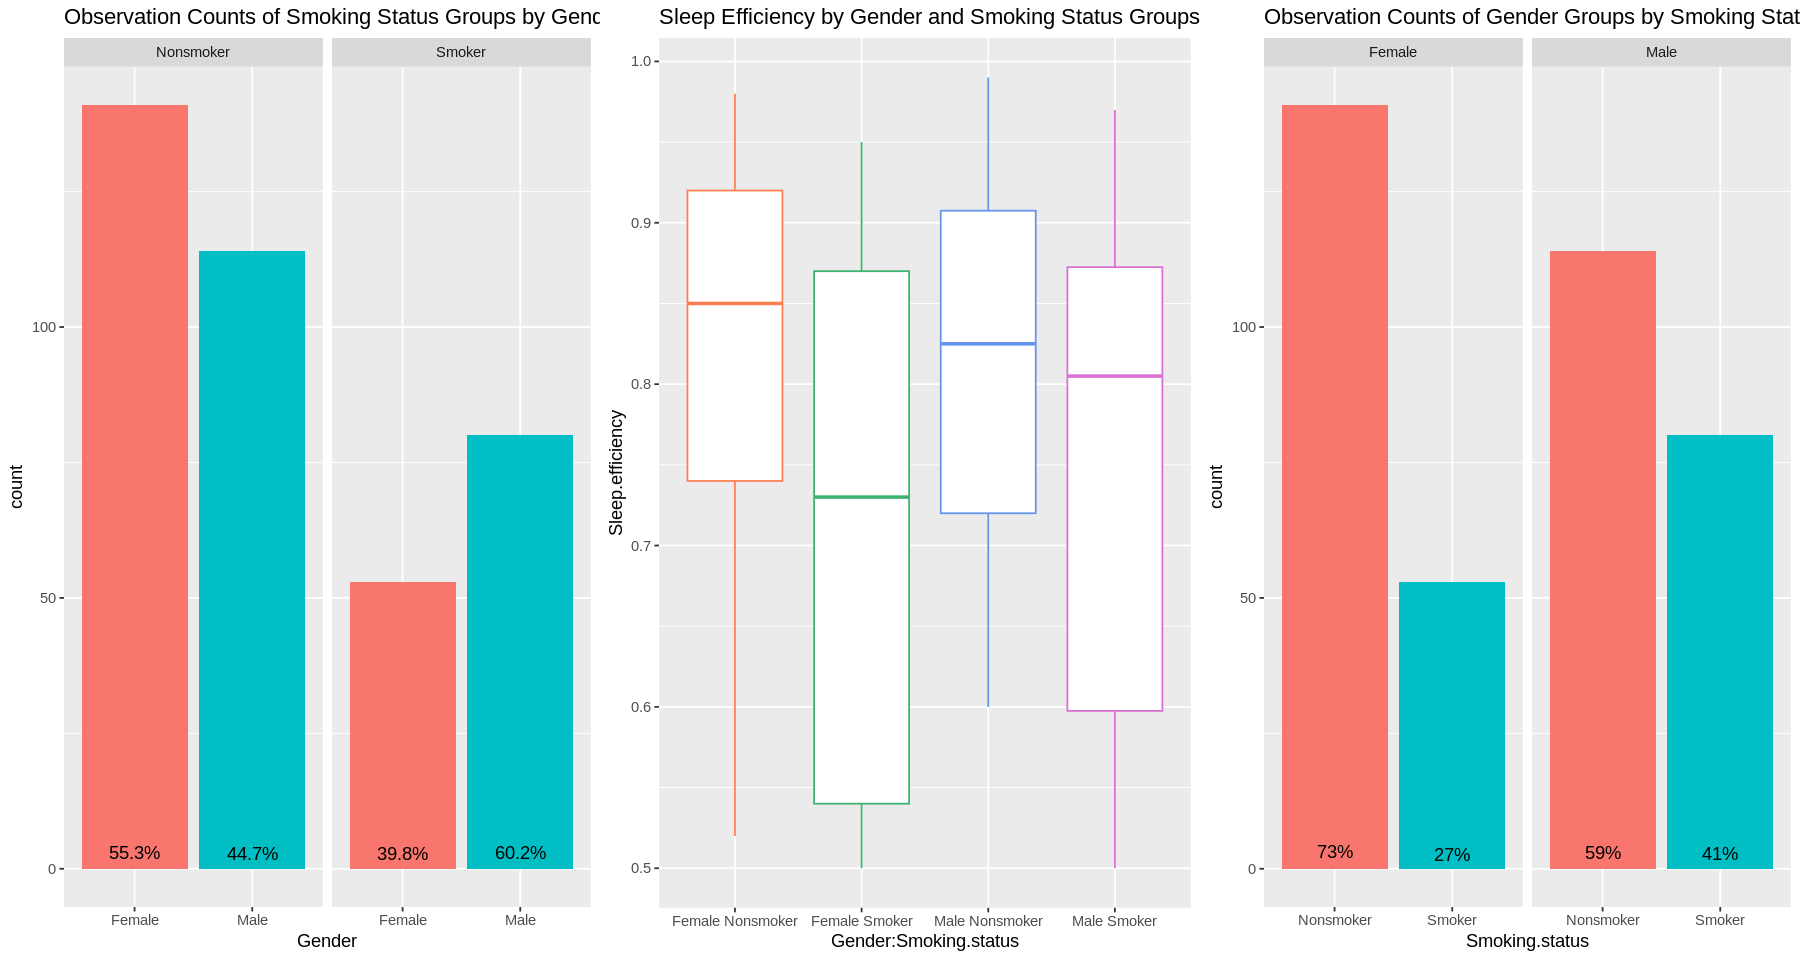

In [48]:
#plot scatterplot and barplots of each categorical variables
options(repr.plot.width=10,repr.plot.height=8)
#create scatterplot partitioned by groups
plot_gender <- ggplot(data, aes(x=Gender)) + 
    geom_bar(aes(y = ..count.., fill = factor(..x..)), stat="count", show.legend=FALSE) +
    geom_text(aes( label = scales::percent(..count../n), y= ..prop.. ), stat= "count", vjust = -.5) +
    scale_x_discrete(labels=c("0" = "Female", "1" = "Male"))+
    ggtitle("Observation Counts of Gender Groups")

plot_smoke <- ggplot(data, aes(x=Smoking.status)) + 
    geom_bar(aes(y = ..count.., fill = factor(..x..)), stat="count", show.legend=FALSE) +
    geom_text(aes( label = scales::percent(..count../n), y= ..prop.. ), stat= "count", vjust = -.5) +
    scale_x_discrete(labels=c('0' = "Nonsmoker",'1' = "Smoker"))+
    ggtitle("Observation Counts of Smoking Status Groups")

plot_genderbysmoke <- ggplot(data, aes(x=Gender,  group=Smoking.status)) + 
    geom_bar(aes(y = ..count.., fill = factor(..x..)), stat="count", show.legend=FALSE) +
    geom_text(aes( label = scales::percent(..prop..),
                   y= ..prop.. ), stat= "count", vjust = -.5) +
    facet_grid(~Smoking.status, labeller=as_labeller(c('0' = "Nonsmoker",'1' = "Smoker"))) +
    scale_x_discrete(labels=c("0" = "Female", "1" = "Male"))+
    ggtitle("Observation Counts of Smoking Status Groups by Gender")

plot_smokebygender <- ggplot(data, aes(x=Smoking.status,  group=Gender)) + 
    geom_bar(aes(y = ..count.., fill = factor(..x..)), stat="count", show.legend=FALSE) +
    geom_text(aes( label = scales::percent(..prop..),
                   y= ..prop.. ), stat= "count", vjust = -.5) +
    facet_grid(~Gender, labeller=as_labeller(c("0" = "Female", "1" = "Male"))) +
    scale_x_discrete(labels=c('0' = "Nonsmoker",'1' = "Smoker"))+
    ggtitle("Observation Counts of Gender Groups by Smoking Status")

#create boxplots to view if there are any siginificant differences between groups
boxplot_gendersmoke <- ggplot(data, aes(Gender:Smoking.status, Sleep.efficiency, color = Gender:Smoking.status)) + 
    geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=FALSE, show.legend=FALSE) + 
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    scale_x_discrete(labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency by Gender and Smoking Status Groups")
boxplot_gender <- ggplot(data, aes(Gender, Sleep.efficiency, color = Gender)) + 
    geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=FALSE, show.legend=FALSE) + 
    scale_color_manual(values = c("mediumseagreen", "cornflowerblue"),labels=c('Female','Male')) +
    scale_x_discrete(labels=c('Female','Male')) +
    ggtitle("Sleep Efficiency by Genders")
boxplot_smoke <- ggplot(data, aes(Smoking.status, Sleep.efficiency, color = Smoking.status)) + 
    geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=FALSE, show.legend=FALSE) + 
    scale_color_manual(values = c("coral", "orchid"),labels=c('Nonsmoker', 'Smoker')) +
    scale_x_discrete(labels=c('Nonsmoker', 'Smoker')) +
    ggtitle("Sleep Efficiency by Smoking Status")

plot_grid(boxplot_gender,plot_gender)
plot_grid(boxplot_smoke,plot_smoke)
options(repr.plot.width=15,repr.plot.height=8)
plot_grid(plot_genderbysmoke,boxplot_gendersmoke,plot_smokebygender, ncol=3)

#### Model Selection - Full Model

Although the dataset has two categorical variables (Gender and Smoking Status), they will be dropped temporarily for the stepwise algorithm; however, we will still test Gender and Smoking Status’s interactions and effects in later models to determine the optimal model.We are going to remove the categorical variables in the stepwise analysis, and will look at them when comparing R^2 and RMES of the models below.

In [49]:
set.seed(2023)

step_data <- data
step_data$ID <- 1:n
step_data_train <- sample_n(step_data,size=0.75*n,replace=FALSE)
step_data_test <- anti_join(step_data,step_data_train,by="ID")

step_data_train <- step_data_train |> 
    select(-ID)
step_data_test <- step_data_test |> 
    select(-ID)

rmse <- function(u,v) {sqrt(mean((u-v)^2))}
head(step_data_train)

,Sleep.efficiency,Age,Gender,Sleep.duration,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Smoking.status,Exercise.frequency
,<dbl>,<int>,<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,0.92,37,0,7.0,25,55,20,1,50,1,0,3
2,0.66,44,1,7.0,20,35,45,4,0,3,1,3
3,0.90,25,0,7.5,28,55,17,1,50,0,1,1
4,0.50,29,0,7.5,22,28,50,1,75,1,1,2
5,0.71,29,0,7.0,22,57,21,1,25,0,0,2
6,0.68,58,1,7.0,18,35,47,1,0,4,1,3


In [50]:
full_model <- lm(Sleep.efficiency~.,data=step_data_train)
pre_full_model <- predict(full_model,step_data_test)

full_model_RMSE <- tibble(Model="Full Model",
                          RMSE=rmse(step_data_train$Sleep.efficiency,pre_full_model))
full_model_RMSE

Warning message in predict.lm(full_model, step_data_test):
“prediction from a rank-deficient fit may be misleading”


Model,RMSE
<chr>,<dbl>
Full Model,0.179383


#### Model Selection - Forward and Backward Selection

In [51]:
forward_select <- summary(regsubsets(x=Sleep.efficiency~.,
                                    nvmax=9,
                                    data=step_data_train,
                                    method="forward"))
forward_cp <- tibble(var=1:10,cp=forward_select$cp) |>
    arrange(cp)
forward_select
forward_cp

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”


Reordering variables and trying again:


Subset selection object
Call: regsubsets.formula(x = Sleep.efficiency ~ ., nvmax = 9, data = step_data_train, 
    method = "forward")
11 Variables  (and intercept)
                       Forced in Forced out
Age                        FALSE      FALSE
Gender1                    FALSE      FALSE
Sleep.duration             FALSE      FALSE
REM.sleep.percentage       FALSE      FALSE
Deep.sleep.percentage      FALSE      FALSE
Awakenings                 FALSE      FALSE
Caffeine.consumption       FALSE      FALSE
Alcohol.consumption        FALSE      FALSE
Smoking.status1            FALSE      FALSE
Exercise.frequency         FALSE      FALSE
Light.sleep.percentage     FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: forward
          Age Gender1 Sleep.duration REM.sleep.percentage Deep.sleep.percentage
1  ( 1 )  " " " "     " "            " "                  " "                  
2  ( 1 )  " " " "     " "            " "                  " "                  
3  ( 1

var,cp
<int>,<dbl>
8,7.560766
7,7.825259
9,8.155684
6,8.713239
10,10.000000
5,10.038861
4,15.169582
3,27.538393
2,66.196913


In [52]:
forward_model <- lm(Sleep.efficiency~Light.sleep.percentage+Awakenings+Smoking.status+Age+Exercise.frequency+Deep.sleep.percentage+Alcohol.consumption+Caffeine.consumption,data=step_data_train)
pre_forward_model <- predict(forward_model,step_data_test)
forward_model_RMSE <- tibble(Model="Forward Model",
                             RMSE=rmse(step_data_train$Sleep.efficiency,pre_forward_model))
forward_model_RMSE

Model,RMSE
<chr>,<dbl>
Forward Model,0.1791468


In [53]:
backward_select <- summary(regsubsets(x=Sleep.efficiency~.,
                                    nvmax=11,
                                    data=step_data_train,
                                    method="backward"))
backward_cp <- tibble(var=1:10,cp=backward_select$cp) |>
    arrange(cp)
backward_select
backward_cp

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”


Reordering variables and trying again:


Warning message in rval$lopt[] <- rval$vorder[rval$lopt]:
“number of items to replace is not a multiple of replacement length”


Subset selection object
Call: regsubsets.formula(x = Sleep.efficiency ~ ., nvmax = 11, data = step_data_train, 
    method = "backward")
11 Variables  (and intercept)
                       Forced in Forced out
Age                        FALSE      FALSE
Gender1                    FALSE      FALSE
Sleep.duration             FALSE      FALSE
REM.sleep.percentage       FALSE      FALSE
Deep.sleep.percentage      FALSE      FALSE
Awakenings                 FALSE      FALSE
Caffeine.consumption       FALSE      FALSE
Alcohol.consumption        FALSE      FALSE
Smoking.status1            FALSE      FALSE
Exercise.frequency         FALSE      FALSE
Light.sleep.percentage     FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: backward
          Age Gender1 Sleep.duration REM.sleep.percentage Deep.sleep.percentage
1  ( 1 )  " " " "     " "            " "                  "*"                  
2  ( 1 )  " " " "     " "            " "                  "*"                  
3  

var,cp
<int>,<dbl>
8,7.560766
7,7.825259
9,8.155684
6,8.713239
10,10.000000
5,13.939406
4,25.947685
3,65.479458
2,122.022158


In [54]:
backward_model <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Smoking.status+Age+Exercise.frequency+Alcohol.consumption+Caffeine.consumption,data=step_data_train)
pre_backward_model <- predict(backward_model,step_data_test)
backward_model_RMSE <- tibble(Model="Backward Model",
                             RMSE=rmse(step_data_train$Sleep.efficiency,pre_backward_model))
backward_model_RMSE

Model,RMSE
<chr>,<dbl>
Backward Model,0.1791468


#### RMSE Comparison of the Models

In [55]:
rbind(full_model_RMSE,forward_model_RMSE,backward_model_RMSE) |>
arrange(RMSE)

Model,RMSE
<chr>,<dbl>
Backward Model,0.1791468
Forward Model,0.1791468
Full Model,0.1793830


Based on the stepwise data, it is wise to use the full model.

#### Linear Models

In [56]:
model1 <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Exercise.frequency+Smoking.status + Gender + Alcohol.consumption,data=data)
#model2 <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Exercise.frequency+Smoking.status+ Alcohol.consumption,data=data)
model2 <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Smoking.status,data=data)
model2b <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Exercise.frequency+Smoking.status+ Alcohol.consumption,data=data)
#summary(model1)
summary(model2)
#summary(model2b)
#based on the above, we should not use gender, as it doesnot help our case, also caffeine consumption might not be neccessary
#model3 <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Exercise.frequency+Smoking.status+Smoking.status*Alcohol.consumption,data=data)
#model4 <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Exercise.frequency+Smoking.status+Smoking.status*Alcohol.consumption+Deep.sleep.percentage*Awakenings,data=data)
#summary(model3)
#summary(model4)
#model5 <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Exercise.frequency+Smoking.status+Smoking.status*Alcohol.consumption+Deep.sleep.percentage*Awakenings+REM.sleep.percentage*Awakenings,data=data)

#summary(model5)
model6 <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Smoking.status+Deep.sleep.percentage*Awakenings+REM.sleep.percentage*Awakenings,data=data)
summary(model6)


#model6 is best model with interaction, model 2 is the best one to choose if no interaction.
model7<- lm(Sleep.efficiency~Light.sleep.percentage+Awakenings+Age+Exercise.frequency,data=data)
#summary(model7)
#Forward Selction model


Call:
lm(formula = Sleep.efficiency ~ Deep.sleep.percentage + Awakenings + 
    REM.sleep.percentage + Age + Smoking.status, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.162181 -0.039463  0.009118  0.042276  0.134084 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.3503909  0.0292017  11.999  < 2e-16 ***
Deep.sleep.percentage  0.0058569  0.0002247  26.060  < 2e-16 ***
Awakenings            -0.0344132  0.0024748 -13.906  < 2e-16 ***
REM.sleep.percentage   0.0073343  0.0009378   7.821 5.17e-14 ***
Age                    0.0008451  0.0002354   3.591 0.000373 ***
Smoking.status1       -0.0456971  0.0068018  -6.718 6.69e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06189 on 382 degrees of freedom
Multiple R-squared:  0.7947,	Adjusted R-squared:  0.792 
F-statistic: 295.7 on 5 and 382 DF,  p-value: < 2.2e-16



Call:
lm(formula = Sleep.efficiency ~ Deep.sleep.percentage + Awakenings + 
    REM.sleep.percentage + Age + Smoking.status + Deep.sleep.percentage * 
    Awakenings + REM.sleep.percentage * Awakenings, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.159283 -0.037389  0.006552  0.042800  0.131718 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.1348573  0.0463929   2.907 0.003865 ** 
Deep.sleep.percentage             0.0082022  0.0004230  19.390  < 2e-16 ***
Awakenings                        0.0663981  0.0197944   3.354 0.000875 ***
REM.sleep.percentage              0.0110278  0.0014117   7.812 5.57e-14 ***
Age                               0.0008026  0.0002239   3.585 0.000381 ***
Smoking.status1                  -0.0467218  0.0064836  -7.206 3.12e-12 ***
Deep.sleep.percentage:Awakenings -0.0010606  0.0001658  -6.395 4.71e-10 ***
Awakenings:REM.sleep.percentage  -0.0019084  0

#### Quadratic Models

In [57]:
# model1q is the best quadratic model without interactions, model2q with interactions

#model1q <- lm(Sleep.efficiency~I(Awakenings^2)+I(Deep.sleep.percentage^2)+I(Alcohol.consumption^2)+Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Smoking.status,data=data)
model1q <- lm(Sleep.efficiency~I(Awakenings^2)+I(Deep.sleep.percentage^2)+Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Smoking.status,data=data)
summary(model1q)
#model2q <- lm(Sleep.efficiency~I(Awakenings^2)+I(Deep.sleep.percentage^2)+I(Alcohol.consumption^2)+Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Exercise.frequency+Smoking.status+ Alcohol.consumption+Deep.sleep.percentage*Awakenings+REM.sleep.percentage*Awakenings+Caffeine.consumption+Caffeine.consumption*Sleep.duration+Smoking.status*Sleep.duration+Alcohol.consumption*Sleep.duration,data=data)
model2q <- lm(Sleep.efficiency~I(Awakenings^2)+I(Deep.sleep.percentage^2)+Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Smoking.status+Deep.sleep.percentage*Awakenings+REM.sleep.percentage*Awakenings,data=data)
summary(model2q)


Call:
lm(formula = Sleep.efficiency ~ I(Awakenings^2) + I(Deep.sleep.percentage^2) + 
    Deep.sleep.percentage + Awakenings + REM.sleep.percentage + 
    Age + Smoking.status, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.148351 -0.039485  0.005257  0.038512  0.133470 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 3.487e-01  3.663e-02   9.520  < 2e-16 ***
I(Awakenings^2)             1.204e-02  1.922e-03   6.265 1.01e-09 ***
I(Deep.sleep.percentage^2) -2.902e-05  1.678e-05  -1.730   0.0844 .  
Deep.sleep.percentage       8.281e-03  1.527e-03   5.424 1.04e-07 ***
Awakenings                 -8.237e-02  8.051e-03 -10.230  < 2e-16 ***
REM.sleep.percentage        6.588e-03  9.399e-04   7.009 1.10e-11 ***
Age                         8.806e-04  2.237e-04   3.937 9.82e-05 ***
Smoking.status1            -4.248e-02  6.527e-03  -6.508 2.41e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.


Call:
lm(formula = Sleep.efficiency ~ I(Awakenings^2) + I(Deep.sleep.percentage^2) + 
    Deep.sleep.percentage + Awakenings + REM.sleep.percentage + 
    Age + Smoking.status + Deep.sleep.percentage * Awakenings + 
    REM.sleep.percentage * Awakenings, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.150600 -0.037977  0.004967  0.041901  0.131088 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       1.569e-01  5.382e-02   2.915 0.003774 ** 
I(Awakenings^2)                   8.459e-03  2.003e-03   4.223 3.02e-05 ***
I(Deep.sleep.percentage^2)       -3.904e-05  1.678e-05  -2.326 0.020547 *  
Deep.sleep.percentage             1.112e-02  1.634e-03   6.808 3.91e-11 ***
Awakenings                        9.048e-03  2.316e-02   0.391 0.696288    
REM.sleep.percentage              9.169e-03  1.448e-03   6.332 6.87e-10 ***
Age                               8.433e-04  2.175e-04   3.878 0.00012

In [58]:
rmse(model2$fitted.values, data$Sleep.efficiency)
rmse(model6$fitted.values, data$Sleep.efficiency)
rmse(model7$fitted.values, data$Sleep.efficiency)
rmse(model1q$fitted.values, data$Sleep.efficiency)
rmse(model2q$fitted.values, data$Sleep.efficiency)

[1] 0.06141291

[1] 0.05821737

[1] 0.06461441

[1] 0.05818322

[1] 0.05635638

#### Error Analysis with Residual Plots

,data.Deep.sleep.percentage,model2.fitted.values,model2.residuals
,<int>,<dbl>,<dbl>
1,70,0.9016280,-0.02162799
2,28,0.5631125,0.09688746
3,70,0.9064523,-0.01645231
4,25,0.5503702,-0.04037019
5,55,0.8154791,-0.05547906
7,25,0.6104680,-0.07046803


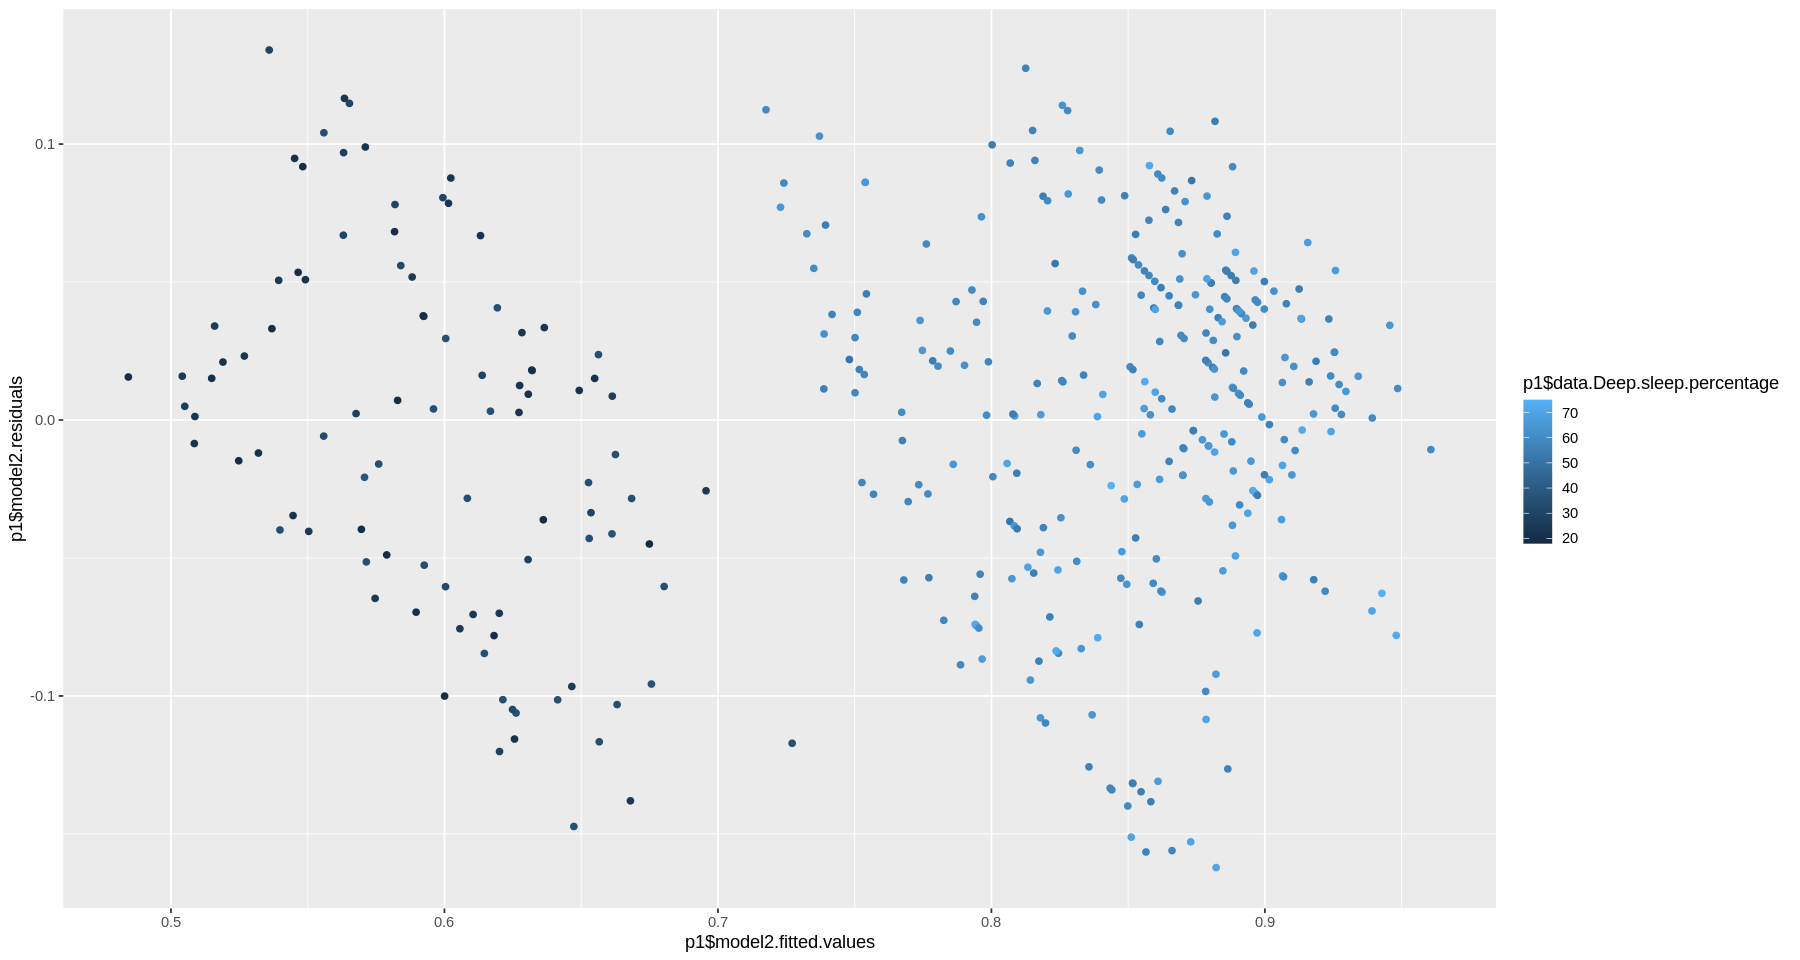

In [59]:
p1 <- data.frame(data$Deep.sleep.percentage, model2$fitted.values, model2$residuals)
head(p1)
plot1 <- ggplot(p1, aes(x=p1$model2.fitted.values, y = p1$model2.residuals)) + geom_point(aes(colour = p1$data.Deep.sleep.percentage))
plot1

,data.Deep.sleep.percentage,model6.fitted.values,model6.residuals
,<int>,<dbl>,<dbl>
1,70,0.9129623,-0.03296230
2,28,0.5840333,0.07596666
3,70,0.9156632,-0.02566319
4,25,0.5669073,-0.05690728
5,55,0.7990973,-0.03909731
7,25,0.5965379,-0.05653790


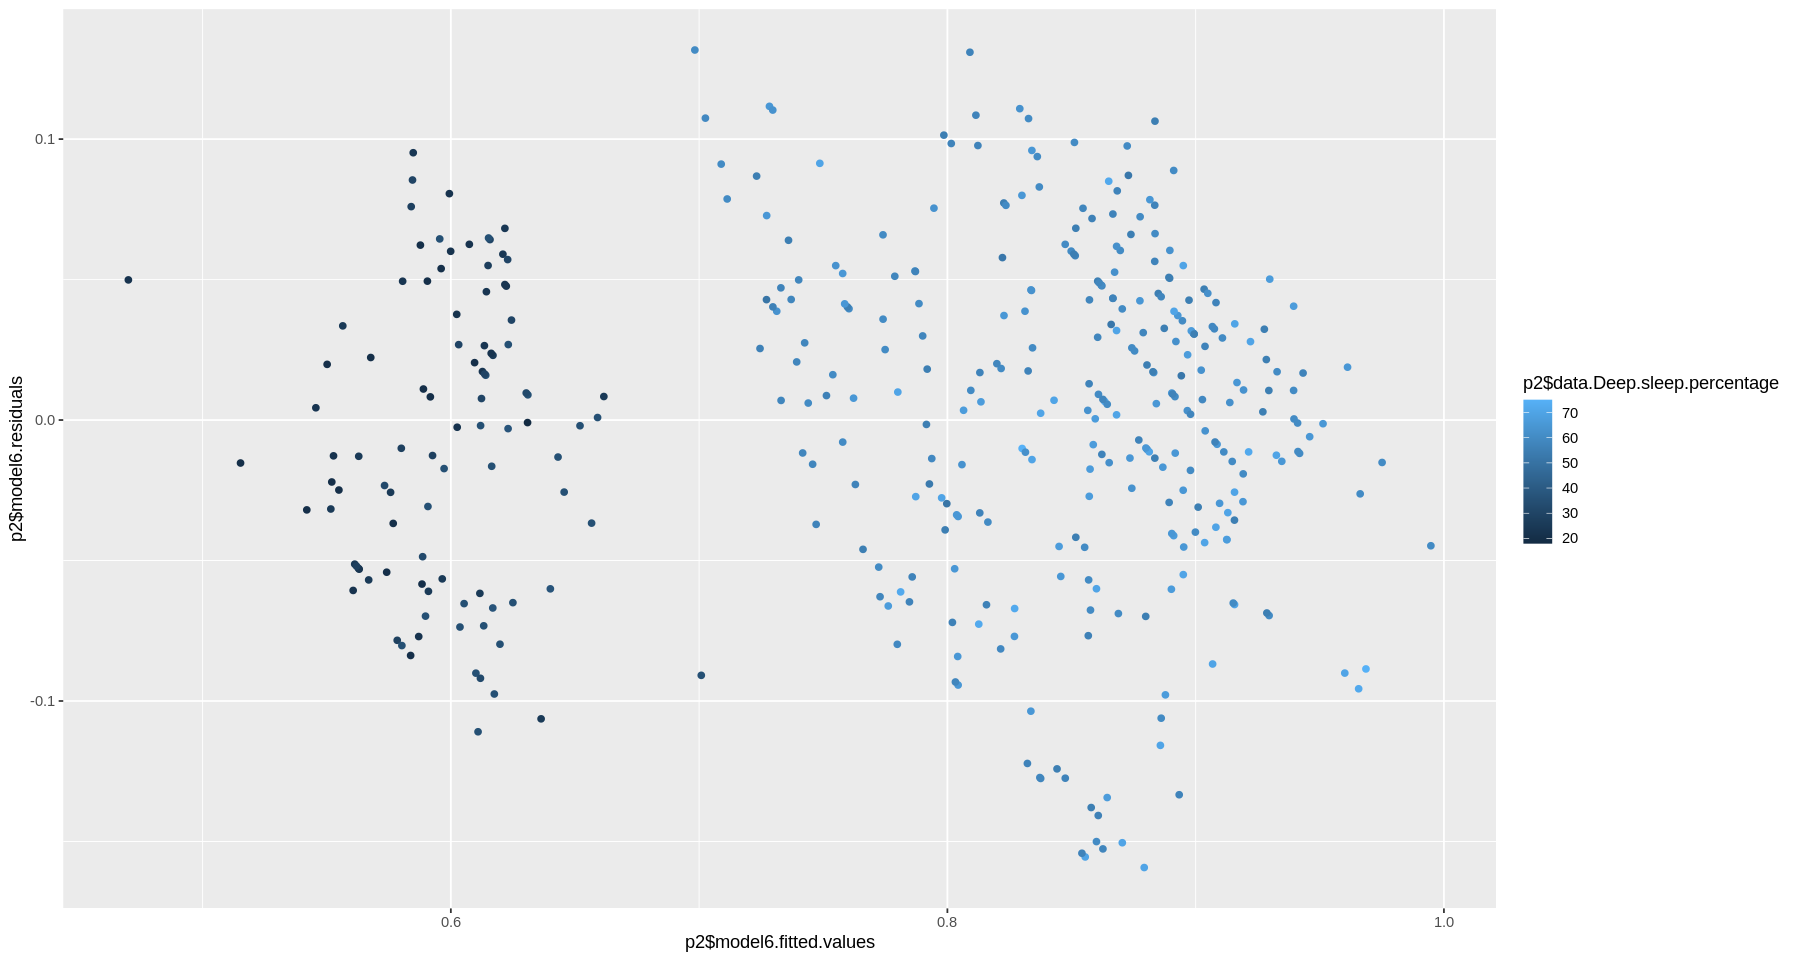

In [60]:
#stdres <- rstandard(model6)
p2 <- data.frame(data$Deep.sleep.percentage, model6$fitted.values, model6$residuals)
#p2 <- data.frame(data$Deep.sleep.percentage, model6$fitted.values, rstandard(model6))
head(p2)
plot2 <- ggplot(p2, aes(x=p2$model6.fitted.values, y = p2$model6.residuals)) + geom_point(aes(colour = p2$data.Deep.sleep.percentage))
#plot2 <- ggplot(p2, aes(x=p2$model6.fitted.values, y = p2$rstandard.model6.)) + geom_point(aes(colour = p2$data.Deep.sleep.percentage))
plot2

,data.Deep.sleep.percentage,model1q.fitted.values,model1q.residuals
,<int>,<dbl>,<dbl>
1,70,0.9195054,-0.039505444
2,28,0.5625504,0.097449617
3,70,0.8828206,0.007179393
4,25,0.5431358,-0.033135830
5,55,0.8057168,-0.045716800
7,25,0.5867763,-0.046776343


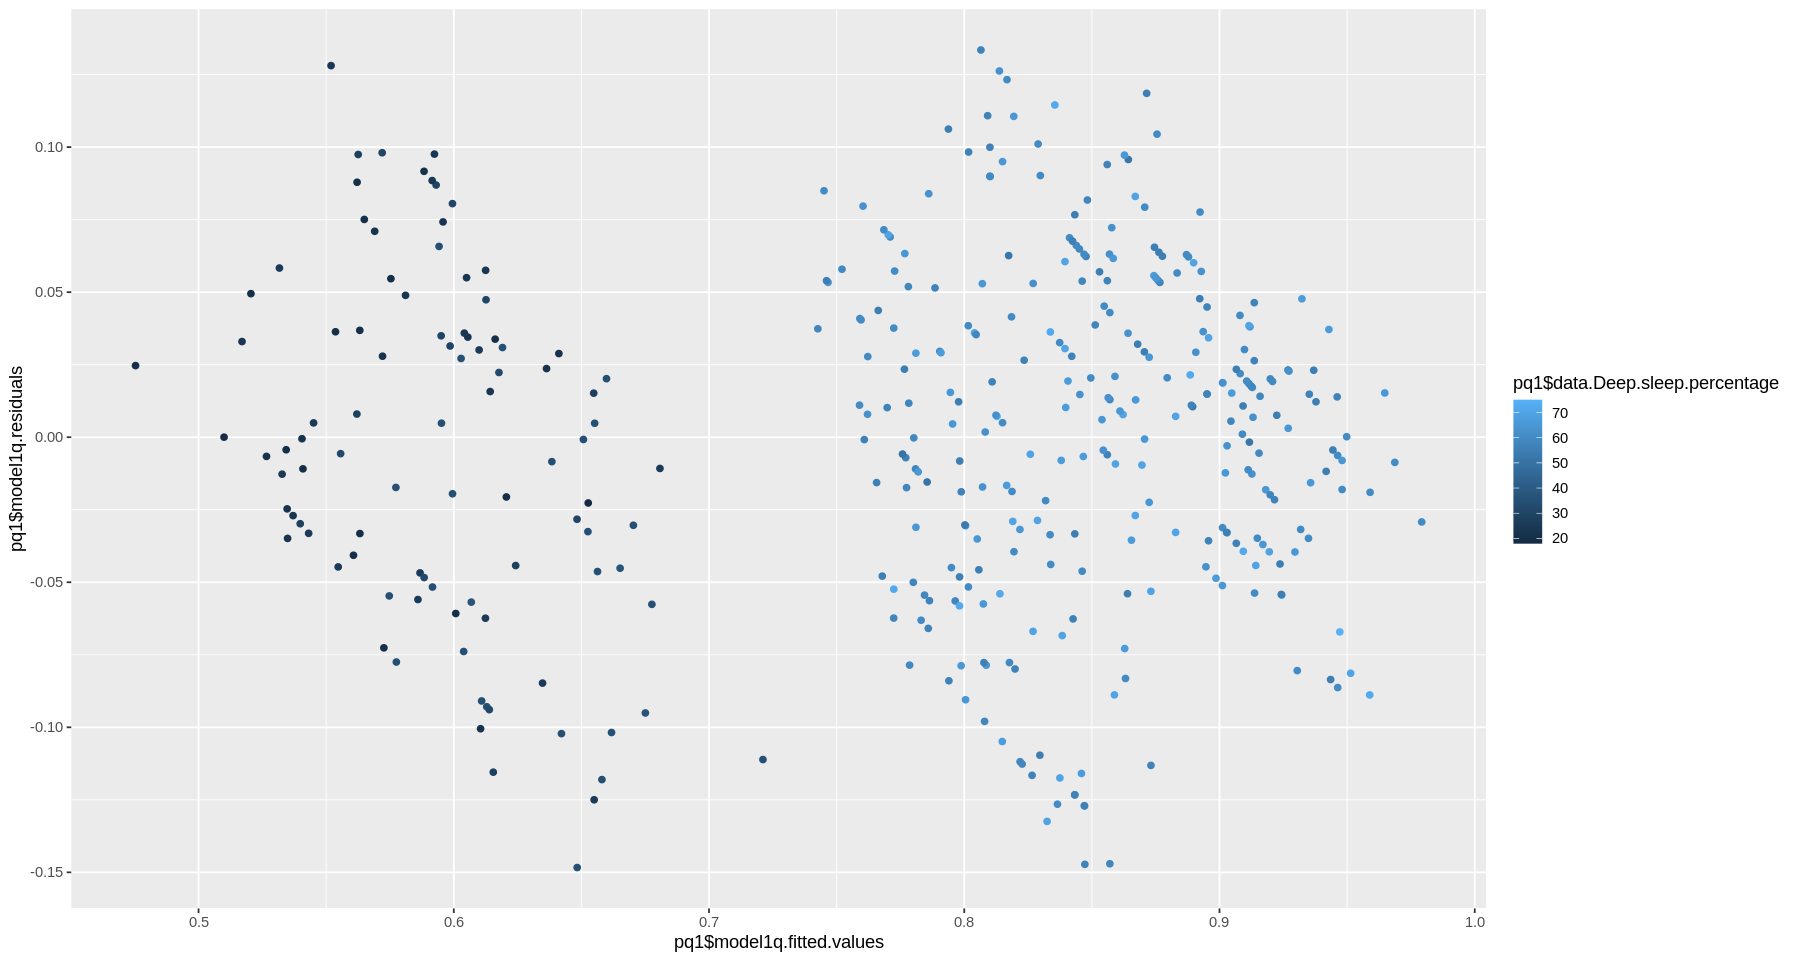

In [61]:
pq1 <- data.frame(data$Deep.sleep.percentage, model1q$fitted.values, model1q$residuals)
head(pq1)
plotq1 <- ggplot(pq1, aes(x=pq1$model1q.fitted.values, y = pq1$model1q.residuals)) + geom_point(aes(colour = pq1$data.Deep.sleep.percentage))
plotq1

,data.Deep.sleep.percentage,model2q.fitted.values,model2q.residuals
,<int>,<dbl>,<dbl>
1,70,0.9206656,-0.040665569
2,28,0.5811329,0.078867083
3,70,0.8919990,-0.001999031
4,25,0.5576132,-0.047613192
5,55,0.7989739,-0.038973894
7,25,0.5800850,-0.040084954


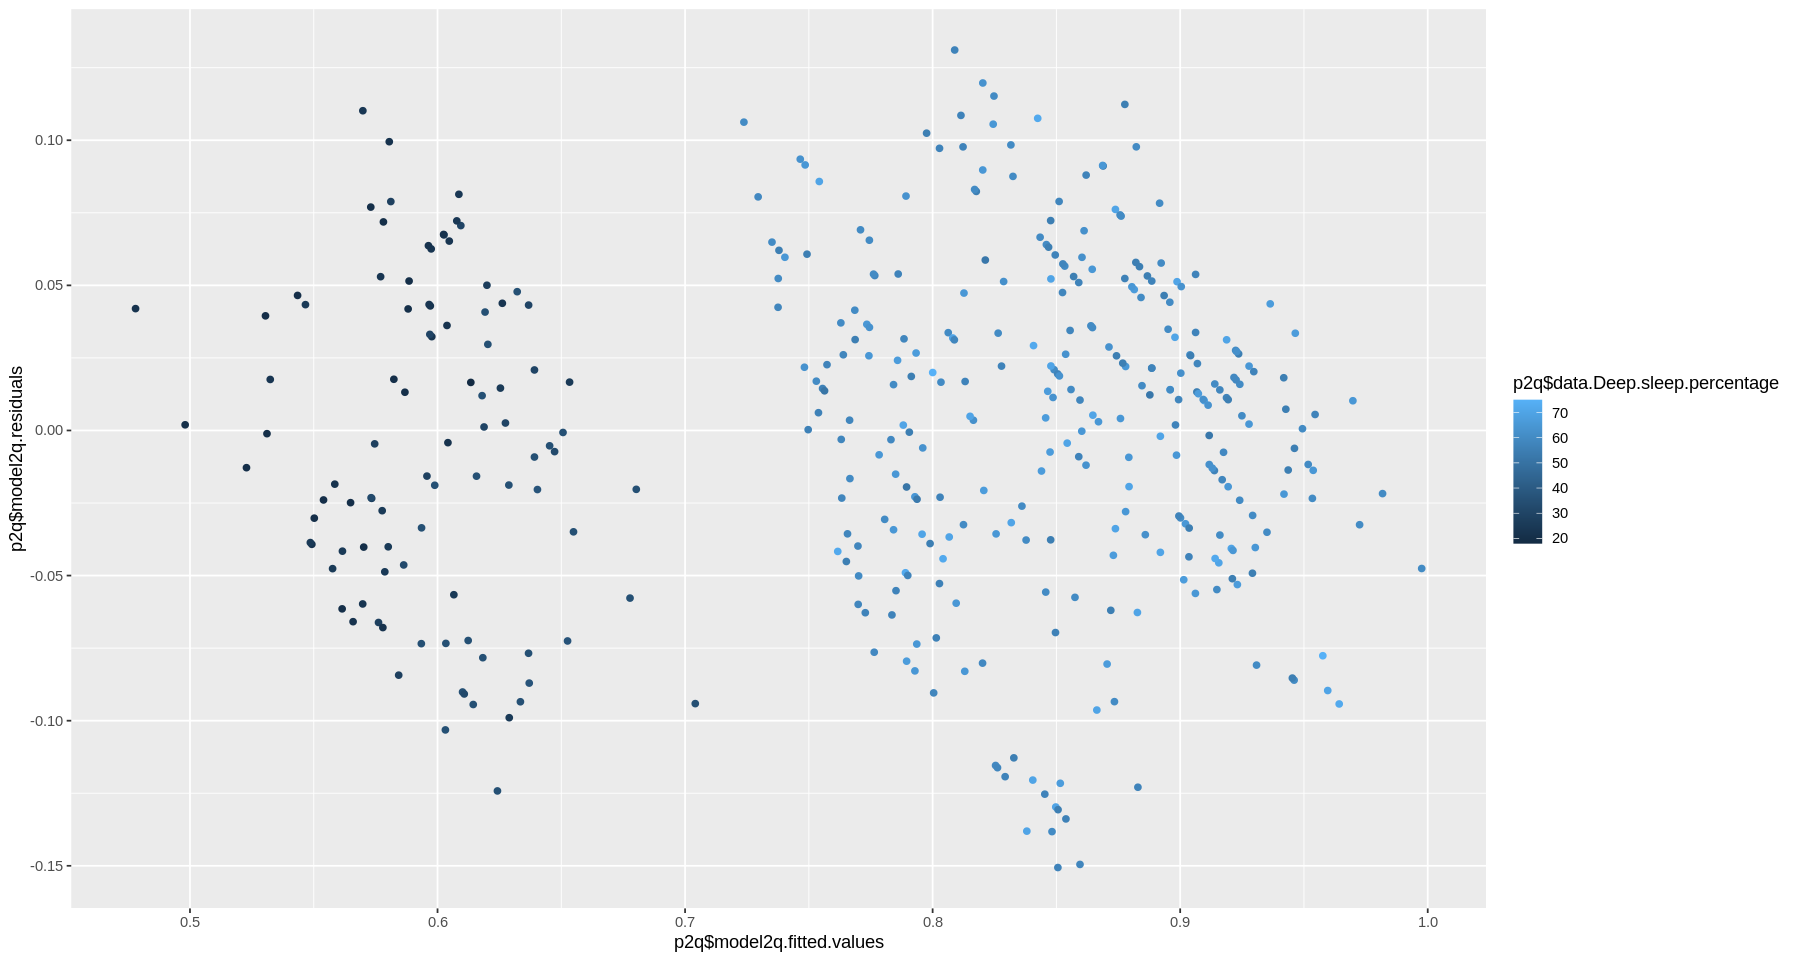

In [62]:
p2q <- data.frame(data$Deep.sleep.percentage, model2q$fitted.values, model2q$residuals)
head(p2q)
plot2q <- ggplot(p2q, aes(x=p2q$model2q.fitted.values, y = p2q$model2q.residuals)) + geom_point(aes(colour = p2q$data.Deep.sleep.percentage))
plot2q

,data.Deep.sleep.percentage,model7.fitted.values,model7.residuals
,<int>,<dbl>,<dbl>
1,70,0.9430371,-0.06303706
2,28,0.5982254,0.06177456
3,70,0.9043240,-0.01432398
4,25,0.5712759,-0.06127587
5,55,0.8041791,-0.04417905
7,25,0.6240666,-0.08406663


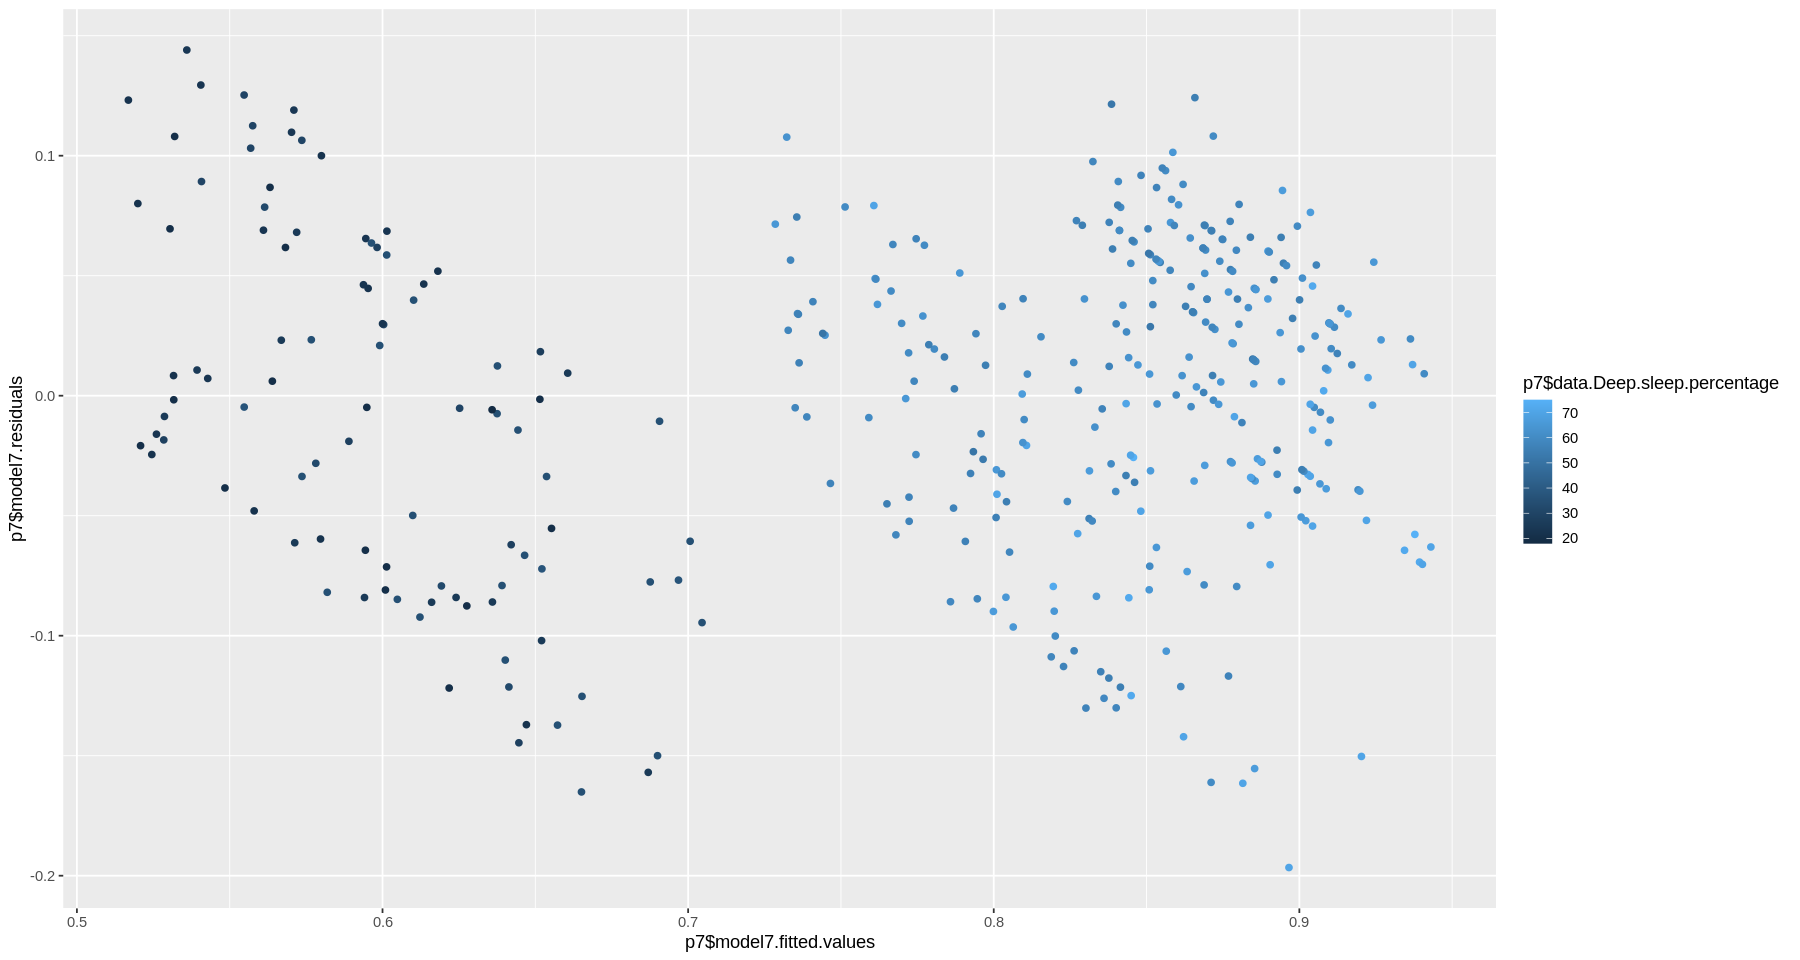

In [63]:
p7 <- data.frame(data$Deep.sleep.percentage, model7$fitted.values, model7$residuals)
head(p7)
plot7 <- ggplot(p7, aes(x=p7$model7.fitted.values, y = p7$model7.residuals)) + geom_point(aes(colour = p7$data.Deep.sleep.percentage))
plot7

We chose to use the Interacting Quadratic Model, as it was better in the R^2 and the RMES Calculation.